In [92]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [93]:
import numpy as np
from graph.structure import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.prior.support_prior import SupportPrior
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from core.linalg_utils import circular_aperture

In [94]:
# パラメータ設定
shape = (64, 64)
support = circular_aperture(shape, radius=0.25)
rng = np.random.default_rng(42)

In [95]:
# グラフ定義
class MultiplyTestGraph(Graph):
    def __init__(self):
        super().__init__()
        X = GaussianPrior(var = 1.0, shape = shape, label="X")
        Y = GaussianPrior(var = 1.0, shape = shape, label="Y")
        Z = X * Y  # MultiplyPropagatorを介して構成される

        # 測定ノード（適当なものでOK）
        self.meas = AmplitudeMeasurement(var=1e-3) @ (FFT2DPropagator() @ Z)
        self.compile()

In [96]:
g = MultiplyTestGraph()

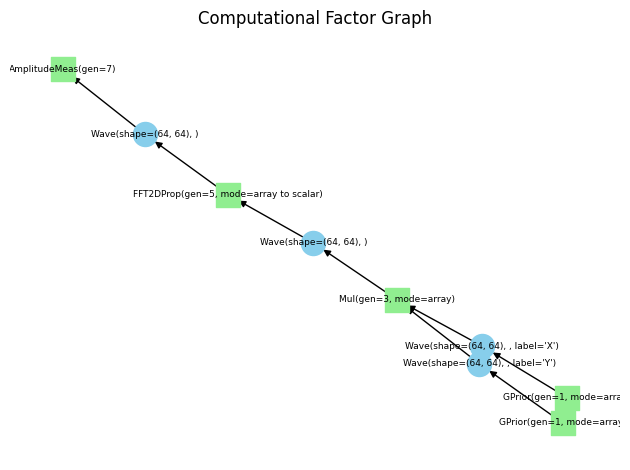

In [97]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

BP Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

[t=0] PMSE = 1.68914e+00
[t=1] PMSE = 2.10784e-03
[t=2] PMSE = 1.86396e-04
[t=3] PMSE = 1.83536e-04
[t=4] PMSE = 1.83522e-04
[t=5] PMSE = 1.83522e-04
[t=6] PMSE = 1.83522e-04
[t=7] PMSE = 1.83522e-04
[t=8] PMSE = 1.83522e-04
[t=9] PMSE = 1.83522e-04


BP Iteration: 100%|██████████| 10/10 [00:00<00:00, 807.50it/s]


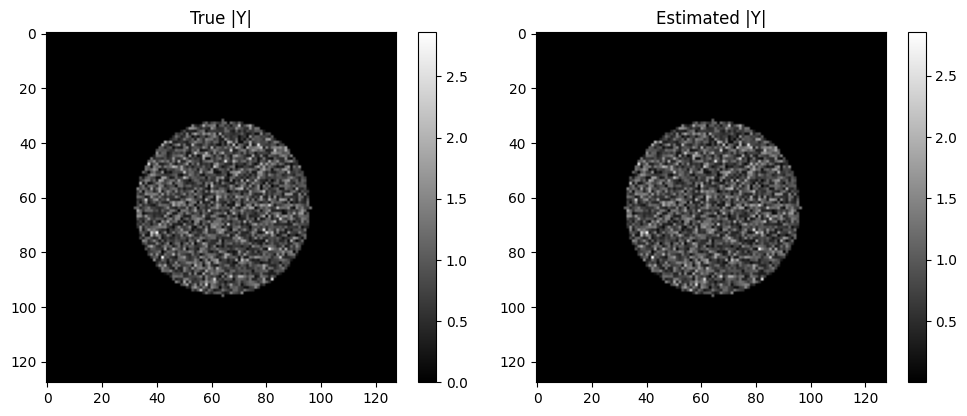

In [98]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.linalg_utils import random_normal_array, circular_aperture
from core.metrics import pmse
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.support_prior import SupportPrior
from graph.measurement.gaussian_measurement import GaussianMeasurement
from graph.propagator.multiply_propagator import MultiplyPropagator

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
large_value = 1e6
rng = np.random.default_rng(42)

# Known input X
x_ref = random_normal_array(shape, dtype=np.complex128, rng=rng)

# Support for unknown Y
support = circular_aperture(shape, radius=0.25)

# ==== 2. グラフ定義 ====
class MultiplyGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = ConstWave(data=x_ref, large_value=large_value, label="X_ref")
        self.Y = SupportPrior(support=support, label="Y_unknown")
        self.Z = self.X * self.Y  # MultiplyPropagator via __mul__
        self.meas = GaussianMeasurement(var=var) @ self.Z
        self.compile()

# ==== 3. 初期化と推論 ====
g = MultiplyGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=123), update_observed=True)

true_y = g.get_wave("Y_unknown").get_sample()

def monitor(graph, t):
    est = graph.get_wave("Y_unknown").compute_belief().data
    err = pmse(est, true_y)
    print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=10, callback=monitor)

# ==== 4. 可視化 ====
est = g.get_wave("Y_unknown").compute_belief().data

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("True |Y|")
plt.imshow(np.abs(true_y), cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Estimated |Y|")
plt.imshow(np.abs(est), cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

In [99]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import random_normal_array, circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.propagator.add_propagator import AddPropagator
from graph.propagator.multiply_propagator import MultiplyPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(123)
x = random_normal_array(shape, rng=rng)
y = random_normal_array(shape, rng=rng)
z = random_normal_array(shape, rng=rng)

# ==== 2. グラフ定義 ====
class MixedMeasurementGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = ConstWave(data=x, label="X")
        self.Y = ConstWave(data=y, label="Y")
        self.Z = ConstWave(data=z, label="Z")
        self.W = GaussianPrior(shape=shape, var=1.0, label="W_unknown")

        # Define paths
        A1 = self.X * self.W
        A2 = self.Y * self.W
        A3 = self.Z * self.W

        # Measurements
        self.M1 = AmplitudeMeasurement(var=var, damping = 0.3) @ (FFT2DPropagator(shape) @ A1)
        self.M2 = AmplitudeMeasurement(var=var, damping = 0.3) @ (FFT2DPropagator(shape) @ A2)
        self.M3 = AmplitudeMeasurement(var=var, damping = 0.3) @ (FFT2DPropagator(shape) @ A3)

        self.compile()

# ==== 3. 推論・初期化 ====
g = MixedMeasurementGraph()
g.set_init_rng(np.random.default_rng(seed=999))
g.generate_sample(rng=np.random.default_rng(seed=100), update_observed=True)

true_w = g.get_wave("W_unknown").get_sample()

def monitor(graph, t):
    est = graph.get_wave("W_unknown").compute_belief().data
    err = pmse(est, true_w)
    if t % 10 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=100, callback=monitor, verbose = None)

[t=0] PMSE = 2.33991e+00
[t=10] PMSE = 2.00796e+00
[t=20] PMSE = 1.98425e+00
[t=30] PMSE = 1.96165e+00
[t=40] PMSE = 1.92653e+00
[t=50] PMSE = 1.75710e+00
[t=60] PMSE = 1.05201e-01
[t=70] PMSE = 7.07436e-03
[t=80] PMSE = 4.78763e-04
[t=90] PMSE = 2.15001e-04


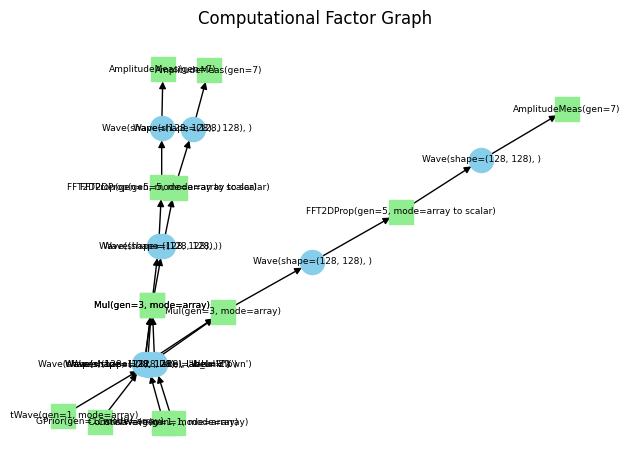

In [100]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

In [101]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=None, verbose = None)

         159604 function calls in 0.671 seconds

   Ordered by: cumulative time
   List reduced from 112 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.671    0.671 {built-in method builtins.exec}
        1    0.000    0.000    0.671    0.671 <string>:1(<module>)
        1    0.000    0.000    0.671    0.671 graph.py:136(run)
      100    0.001    0.000    0.479    0.005 graph.py:131(backward)
      300    0.001    0.000    0.206    0.001 fft_2d_propagator.py:104(backward)
      100    0.001    0.000    0.192    0.002 graph.py:126(forward)
      300    0.030    0.000    0.168    0.001 fft_2d_propagator.py:55(compute_belief)
     1500    0.142    0.000    0.151    0.000 uncertain_array.py:164(__truediv__)
      300    0.001    0.000    0.145    0.000 multiply_propagator.py:113(backward)
      600    0.064    0.000    0.129    0.000 multiply_propagator.py:52(_compute_backward)
      300    0.001    0

In [113]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import random_normal_array, circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.support_prior import SupportPrior
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.propagator.add_propagator import AddPropagator
from graph.propagator.multiply_propagator import MultiplyPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(12)
x_data = random_normal_array(shape, rng=rng)
y_data = random_normal_array(shape, rng=rng)
z_data = random_normal_array(shape, rng=rng)
support = circular_aperture(shape, radius=0.2)

# ==== 2. グラフ定義 ====
class MixedMeasurementGraph(Graph):
    def __init__(self):
        super().__init__()
        o = SupportPrior(support=support, label = "object")
        x = ConstWave(data=x_data, label="X", large_value=1e12)
        y = ConstWave(data=y_data, label="Y", large_value=1e12)
        z = ConstWave(data=z_data, label="Z", large_value=1e12)

        # Define paths
        a = FFT2DPropagator() @ (o * x)
        b = FFT2DPropagator() @ (a * y)
        c = FFT2DPropagator() @ (b * z)

        # Measurements
        self.mes = AmplitudeMeasurement(var=var, damping = 0.3) @ c

        self.compile()

# ==== 3. 推論・初期化 ====
g = MixedMeasurementGraph()
g.set_init_rng(np.random.default_rng(seed=999))
g.generate_sample(rng=np.random.default_rng(seed=100), update_observed=True)

true_object = g.get_wave("object").get_sample()

def monitor(graph, t):
    est = graph.get_wave("object").compute_belief().data
    err = pmse(est, true_object)
    if t % 50 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=100, callback=monitor, verbose = None)

[t=0] PMSE = 4.53220e-01
[t=50] PMSE = 1.23543e-02


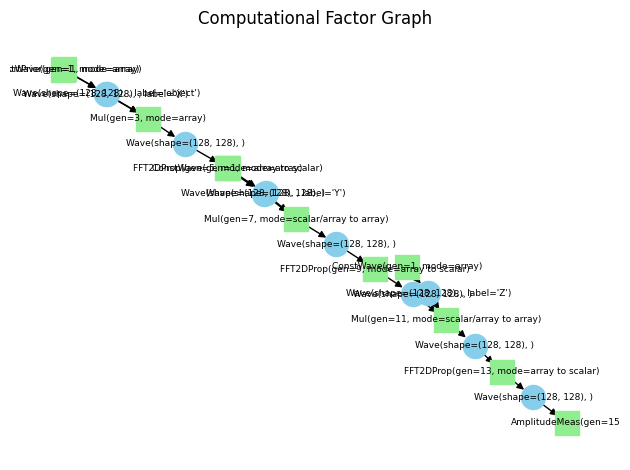

In [103]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

In [104]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=None, verbose = None)

         134404 function calls in 0.487 seconds

   Ordered by: cumulative time
   List reduced from 102 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.487    0.487 {built-in method builtins.exec}
        1    0.000    0.000    0.487    0.487 <string>:1(<module>)
        1    0.000    0.000    0.487    0.487 graph.py:136(run)
      100    0.001    0.000    0.378    0.004 graph.py:131(backward)
      300    0.001    0.000    0.194    0.001 fft_2d_propagator.py:104(backward)
      300    0.027    0.000    0.158    0.001 fft_2d_propagator.py:55(compute_belief)
      300    0.002    0.000    0.146    0.000 multiply_propagator.py:113(backward)
      600    0.057    0.000    0.134    0.000 multiply_propagator.py:52(_compute_backward)
      100    0.001    0.000    0.109    0.001 graph.py:126(forward)
     1200    0.101    0.000    0.107    0.000 uncertain_array.py:164(__truediv__)
      600    0.002    0